In [2]:
import os
import cv2
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Add, Concatenate, Activation, BatchNormalization, MaxPooling2D, Input, DepthwiseConv2D, Lambda, LeakyReLU, Reshape, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Dropout, Flatten
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import Loss
from keras.regularizers import l2
import seaborn as sns
import keras.backend as K
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

# Data set generation and data enhancement

In [3]:
train_dir = '../dsForBinary/train'
validation_dir = '../dsForBinary/validation'
test_dir = '../dsForBinary/test'

def preprocessing_function(image):
    def bilateral_filter(image):
        return cv2.bilateralFilter(image, d=21, sigmaColor=10, sigmaSpace=10)
    filtered_image = tf.numpy_function(bilateral_filter, [image], tf.float32)
    filtered_image.set_shape(image.shape)
    return filtered_image


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15,
    fill_mode='nearest',
    preprocessing_function=preprocessing_function
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15,
    fill_mode='nearest',
    preprocessing_function=preprocessing_function
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    subset='training',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 2179 images belonging to 2 classes.
Found 548 images belonging to 2 classes.
Found 552 images belonging to 2 classes.


2023-12-13 21:04:37.959150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 21:04:37.966390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 21:04:37.966662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

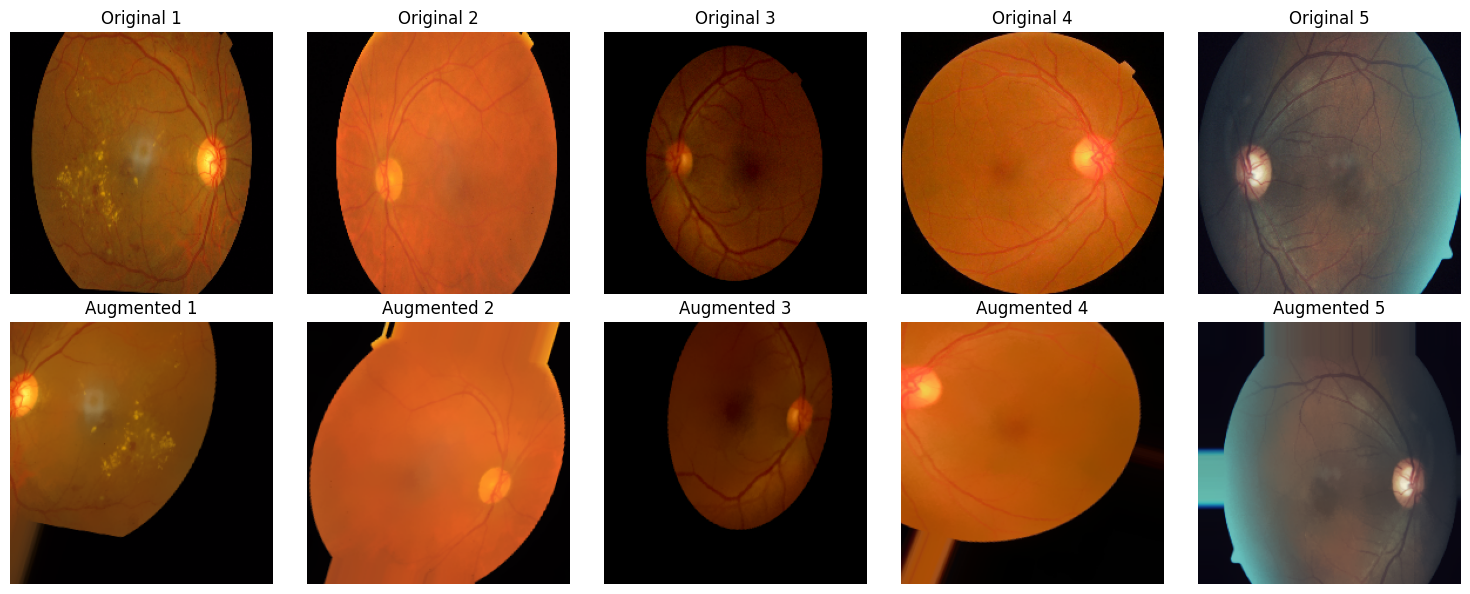

In [4]:
def display_image_augmentation_horizontal(original_gen, augmentation_gen, num_samples=5):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        original_img = next(original_gen)[0][0]
        if np.max(original_img) <= 1:
            original_img = (original_img * 255).astype('uint8')

        axs[0, i].imshow(original_img)
        axs[0, i].set_title(f'Original {i+1}')
        axs[0, i].axis('off')

        augmented_img = next(augmentation_gen.flow(np.expand_dims(original_img, 0), batch_size=1))[0]
        augmented_img = (augmented_img * 255).astype('uint8')

        axs[1, i].imshow(augmented_img)
        axs[1, i].set_title(f'Augmented {i+1}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_image_augmentation_horizontal(test_generator, train_datagen, num_samples=5)


# Creating models and attention mechanisms

In [5]:
def channel_attention_layer(inputs, channels, reduction=8):
    avg_pool = GlobalAveragePooling2D()(inputs)
    max_pool = GlobalMaxPooling2D()(inputs)
    fc1 = Dense(channels // reduction, activation='relu')(avg_pool)
    fc2 = Dense(channels)(fc1)
    fc3 = Dense(channels // reduction, activation='relu')(max_pool)
    fc4 = Dense(channels)(fc3)
    add = Add()([fc2, fc4])
    scale = Activation('sigmoid')(add)
    output = Multiply()([inputs, scale])
    return output

def spatial_attention_layer(inputs):
    avg_out = tf.reduce_mean(inputs, axis=3, keepdims=True)
    max_out = tf.reduce_max(inputs, axis=3, keepdims=True)
    x = Concatenate(axis=3)([avg_out, max_out])
    scale = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(x)
    output = Multiply()([inputs, scale])
    return output

def cbam_module(inputs, channels, reduction=8):
    x = channel_attention_layer(inputs, channels, reduction)
    x = spatial_attention_layer(x)
    return x

In [6]:
def noah_CNN(input_tensor):
    x = Conv2D(32, (1, 1))(input_tensor)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    dilation = Conv2D(32, (1, 1), dilation_rate=2)(x)
    dilation = tf.keras.layers.LeakyReLU(alpha=0.01)(dilation)
    dilation = MaxPooling2D((2, 2))(dilation)

    x = Conv2D(32, (1, 1))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    pool1 = GlobalAveragePooling2D()(x)
    pool1 = Reshape((1, 1, 32))(pool1)
    pool1 = UpSampling2D(size=(x.shape[1] // pool1.shape[1], x.shape[2] // pool1.shape[2]))(pool1)

    x = Concatenate(axis=-1)([dilation, pool1])

    x = cbam_module(x, channels=64)

    output = Flatten()(x)
    return output


def residual_block_with_dwc(inputs, units, adjust_shortcut=False, pool_sizes=[1, 3, 5]):
    convModule = [Conv2D(units, (size, size), padding='same', activation='relu')(inputs) for size in pool_sizes]
    multiScaleFeatures = Concatenate()(convModule)

    poolModule = [MaxPooling2D((size, size), strides=(1, 1), padding='same')(multiScaleFeatures) for size in pool_sizes]
    poolFeatures = Concatenate()(poolModule)

    fusion = Dense(units, activation='relu')(poolFeatures)

    convDWC = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(poolFeatures)
    convPWC = Conv2D(units, kernel_size=(1, 1), padding='same')(convDWC)

    DWCWithFusion = Add()([convPWC, fusion])

    if adjust_shortcut:
        shortcut_conv = Conv2D(units, kernel_size=3, padding="same", kernel_regularizer=l2(0.01))(inputs)
        shortcut = shortcut_conv
    else:
        shortcut = inputs

    out = Add()([DWCWithFusion, shortcut])
    out = tf.nn.leaky_relu(out)
    return out

def model_with_residual(inputs):
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D()(x)

    for i, filters in enumerate([32, 64, 128, 256]):
        adjust_shortcut = (i != 0)
        x = residual_block_with_dwc(x, filters, adjust_shortcut=adjust_shortcut)
        x = MaxPooling2D()(x)
        x = cbam_module(x, channels=filters)
    

    final_output = Flatten()(x)
    return final_output

def create_combined_model():
    input_layer = Input(shape=(224, 224, 3))    

    output1 = model_with_residual(input_layer)
    output2 = noah_CNN(input_layer)


    def apply_weight1(x):
        return x * 0.5

    def apply_weight2(x):
        return x * 0.5  

    weighted_output1 = Lambda(apply_weight1)(output1)
    weighted_output2 = Lambda(apply_weight2)(output2)

    merged_output = Concatenate()([weighted_output1, weighted_output2])

    x = Dense(64)(merged_output)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    final_output = Dense(2, activation='softmax')(x)

    combined_model = Model(inputs=input_layer, outputs=final_output)
    return combined_model

In [7]:
class ConfidenceAwareLoss(tf.keras.losses.Loss):
    def __init__(self, confidence_penalty=0.1, label_smoothing=0.1, 
                 name="confidence_aware_loss", 
                 reduction=tf.keras.losses.Reduction.AUTO):
        super(ConfidenceAwareLoss, self).__init__(name=name, reduction=reduction)
        self.confidence_penalty = confidence_penalty
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.shape(y_true)[-1]
        smooth_positives = 1.0 - self.label_smoothing
        smooth_negatives = self.label_smoothing / tf.cast(num_classes, tf.float32)
        y_true_smoothed = y_true * smooth_positives + smooth_negatives

        confidence = tf.reduce_max(y_pred, axis=-1)

        basic_loss = tf.reduce_mean(tf.square(y_true_smoothed - y_pred), axis=-1)

        confidence_penalty = tf.where(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), 0., self.confidence_penalty * confidence)

        total_loss = basic_loss + confidence_penalty
        return total_loss

    
# class ConfidenceAwareLoss(Loss):
#     def __init__(self, name="categorical_crossentropy", **kwargs):
#         super(ConfidenceAwareLoss, self).__init__(name=name, **kwargs)

#     def call(self, y_true, y_pred):
#         y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
#         return -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
class CustomAccuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        values = tf.cast(tf.equal(y_true, y_pred), 'float32')

        num_samples = tf.cast(tf.size(y_true), 'float32')

        self.total.assign_add(num_samples)
        self.correct.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.correct / self.total

    def reset_state(self): 
        self.correct.assign(0)
        self.total.assign(0)

In [8]:
input_layer = Input(shape=(224, 224, 3))    
model1 = Model(inputs=input_layer, outputs=model_with_residual(input_layer))
model2 = Model(inputs=input_layer, outputs=noah_CNN(input_layer))
combined_model = create_combined_model()
combined_model.summary()

combined_model.compile(optimizer=Adam(learning_rate=0.0005), loss=ConfidenceAwareLoss(), metrics=[CustomAccuracy(), AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,        
    verbose=1,
    restore_best_weights=True 
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,         
    patience=5,         
    min_lr=0.000001,     
    verbose=1
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 112, 112, 32)         2432      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 32)         128       ['conv2d_30[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)   (None, 112, 112, 32)         0         ['batch_normalization_1[

In [9]:
model1_layer = model1.layers[-3].name
model2_layer = model2.layers[-3].name

print(model1_layer)
print(model2_layer)

conv2d_23
conv2d_29


# Model fitting

In [10]:
history = combined_model.fit(train_generator, validation_data = validation_generator, epochs=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/60


2023-12-13 21:04:55.157885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-13 21:04:56.537659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e756950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 21:04:56.537727: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-12-13 21:04:56.547846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 21:04:56.692779: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - 156s 1s/step - loss: 1.6866 - accuracy: 0.6879 - auc: 0.7429 - precision: 0.6879 - recall: 0.6879 - val_loss: 0.7059 - val_accuracy: 0.5602 - val_auc: 0.7543 - val_precision: 0.5602 - val_recall: 0.5602 - lr: 5.0000e-04
Epoch 2/60
91/91 [==============================] - 134s 1s/step - loss: 0.3509 - accuracy: 0.8499 - auc: 0.9115 - precision: 0.8499 - recall: 0.8499 - val_loss: 0.2973 - val_accuracy: 0.5055 - val_auc: 0.7216 - val_precision: 0.5055 - val_recall: 0.5055 - lr: 5.0000e-04
Epoch 3/60
91/91 [==============================] - 135s 1s/step - loss: 0.1641 - accuracy: 0.8678 - auc: 0.9197 - precision: 0.8678 - recall: 0.8678 - val_loss: 0.2201 - val_accuracy: 0.6496 - val_auc: 0.8047 - val_precision: 0.6496 - val_recall: 0.6496 - lr: 5.0000e-04
Epoch 4/60
91/91 [==============================] - 128s 1s/step - loss: 0.1092 - accuracy: 0.8862 - auc: 0.9417 - precision: 0.8862 - recall: 0.8862 - val_loss: 0.1587 - val_accuracy: 0.7810 - v

# Model Evaluation

In [11]:
evaluation_result = combined_model.evaluate(test_generator)

18/18 [==============================] - 2s 95ms/step - loss: 0.0325 - accuracy: 0.9565 - auc: 0.9885 - precision: 0.9565 - recall: 0.9565


# Generate evaluation curves

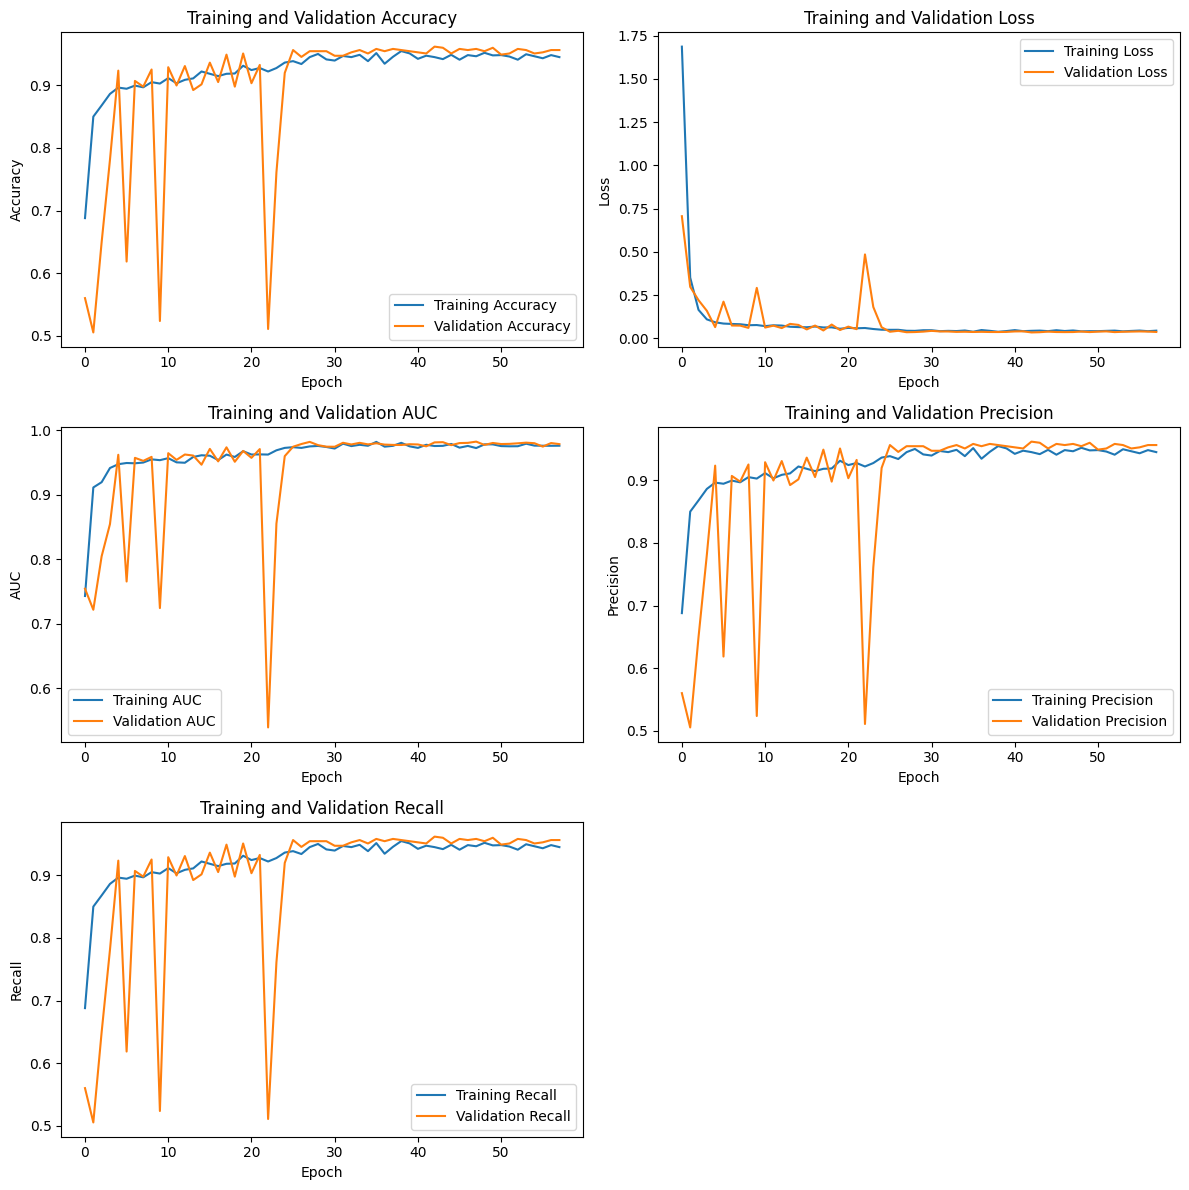

In [12]:
def plot_metrics(epochs, train_metric, val_metric, subplot_title, y_label):
    plt.plot(epochs, train_metric, label='Training ' + y_label)
    plt.plot(epochs, val_metric, label='Validation ' + y_label)
    plt.title(subplot_title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend()

metrics = {
    'Accuracy': ('accuracy', 'val_accuracy'),
    'Loss': ('loss', 'val_loss'),
    'AUC': ('auc', 'val_auc'),
    'Precision': ('precision', 'val_precision'),
    'Recall': ('recall', 'val_recall')
}

epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 12))

for i, (metric_name, (train_key, val_key)) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plot_metrics(epochs, history.history[train_key], history.history[val_key], f'Training and Validation {metric_name}', metric_name)

plt.tight_layout()
plt.show()

In [13]:
combined_model.save(r'model3.h5')

# loaded_model = tf.keras.models.load_model(r'C:\Users\ASUS\Desktop\ModelSave\model.h5')

loaded_model = tf.keras.models.load_model(r'model3.h5', custom_objects={'CustomAccuracy': CustomAccuracy(), 'ConfidenceAwareLoss': ConfidenceAwareLoss()})

evaluation_result = loaded_model.evaluate(test_generator)

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 3s 83ms/step - loss: 0.0325 - accuracy: 0.9565 - auc: 0.9885 - precision: 0.9565 - recall: 0.9565


# Generate Confusion Matrix

17/17 [==============================] - 1s 27ms/step


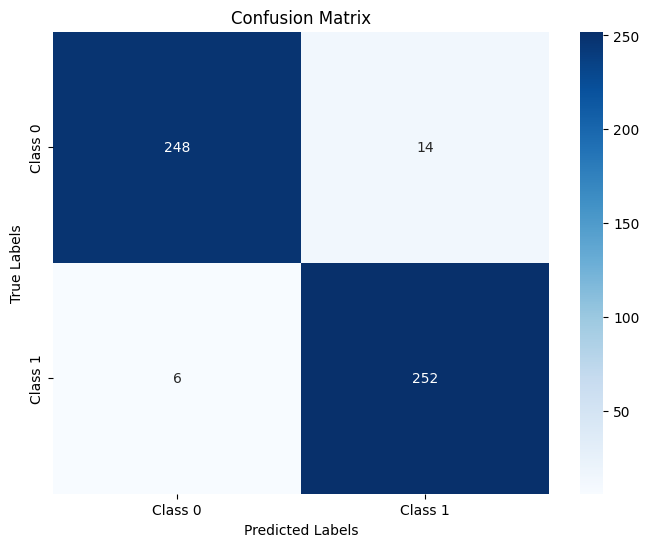

In [14]:
all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)
predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot graphs of recall, precision, sensitivity and specificity.

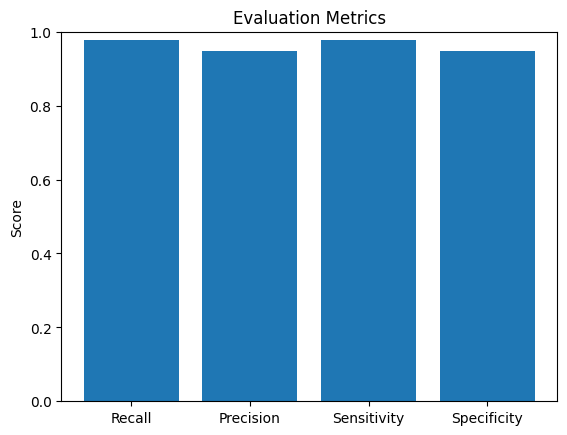

Recall:  0.9767441860465116            Precision:  0.9473684210526315
Sensitivity:  0.9767441860465116       Specificity:  0.9465648854961832


In [15]:
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

recall = TP / (TP + FN)
precision = TP / (TP + FP)
sensitivity = recall
specificity = TN / (TN + FP)

plt.bar(['Recall', 'Precision', 'Sensitivity', 'Specificity'], [recall, precision, sensitivity, specificity])
plt.ylim([0, 1])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()

print("Recall: ", recall, "          " , "Precision: ", precision)
print("Sensitivity: ", sensitivity, "     " , "Specificity: ", specificity)

# Generate ROC curves

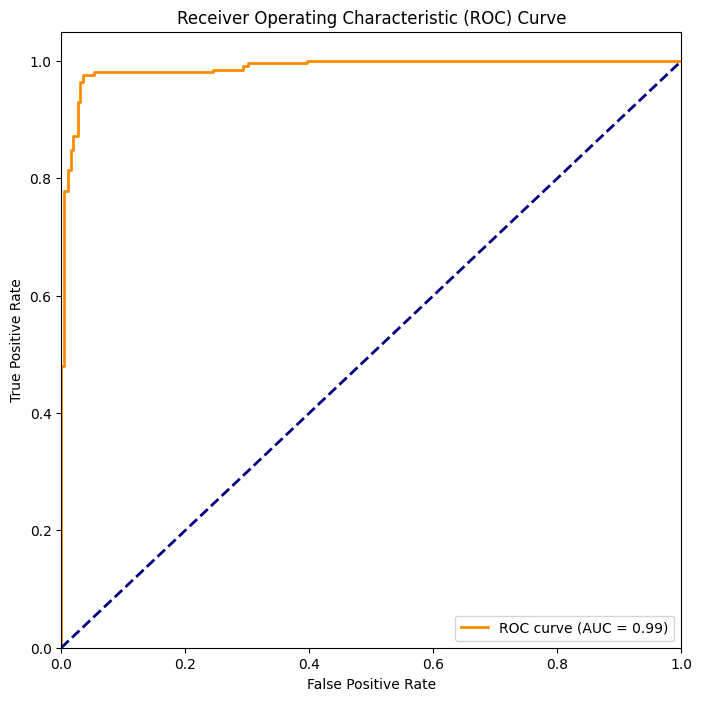

In [16]:
predicted_labels = np.argmax(predictions, axis=1)
fpr, tpr, thresholds = roc_curve(all_true_labels, predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate PRC curves

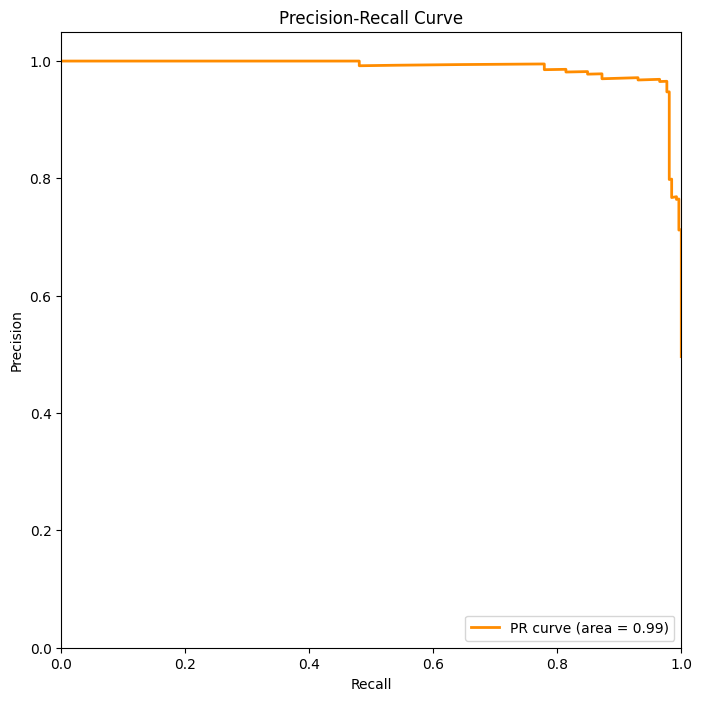

In [17]:
precision, recall, _ = precision_recall_curve(all_true_labels, predictions[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
# plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


# Print F1 Score

In [18]:
f1 = f1_score(all_true_labels, predicted_labels)

print("F1 Score:", f1)

F1 Score: 0.9618320610687022


# Generating heat maps of attention mechanisms

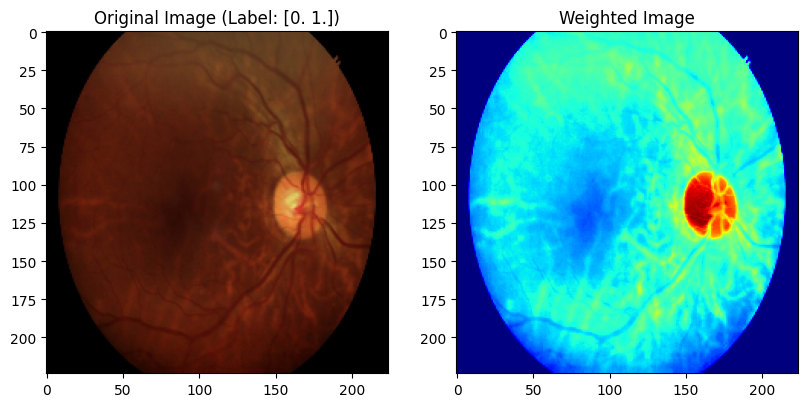

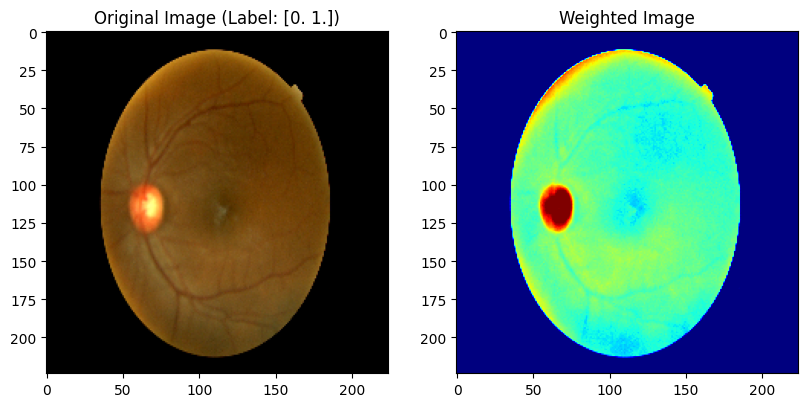

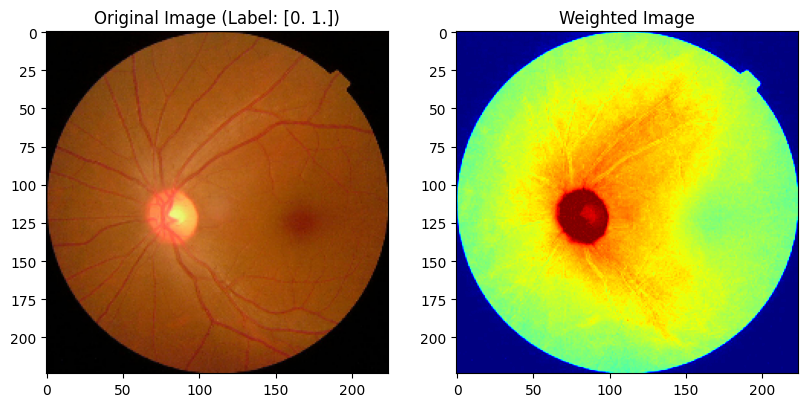

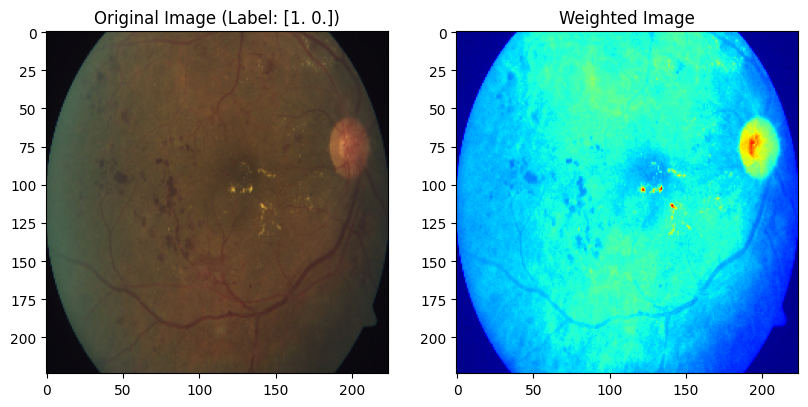

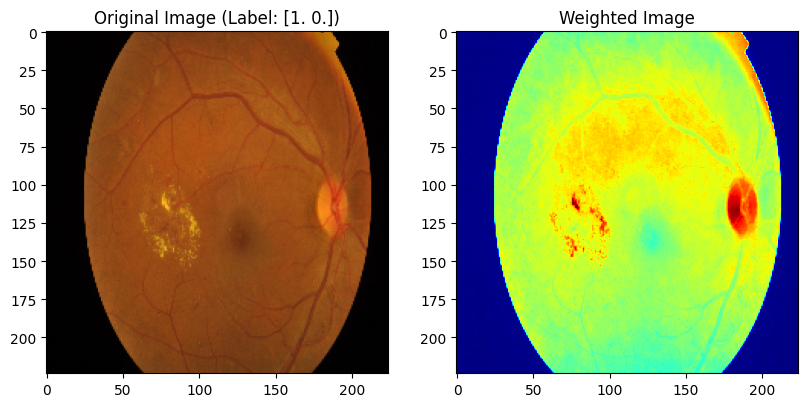

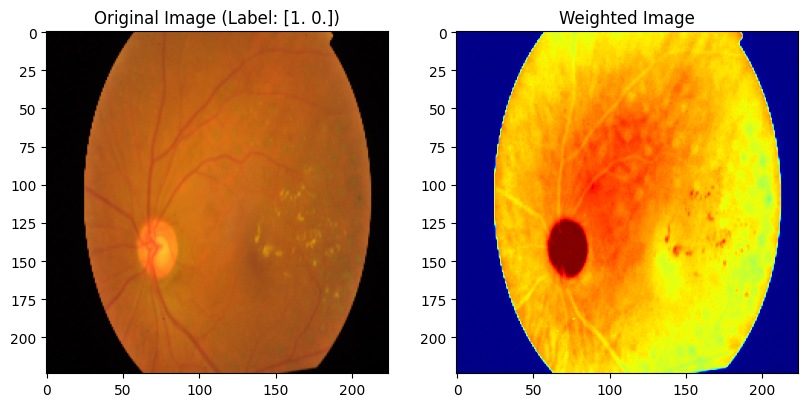

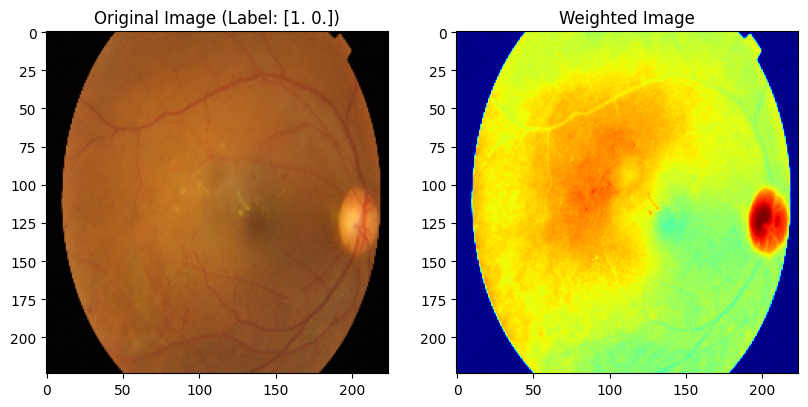

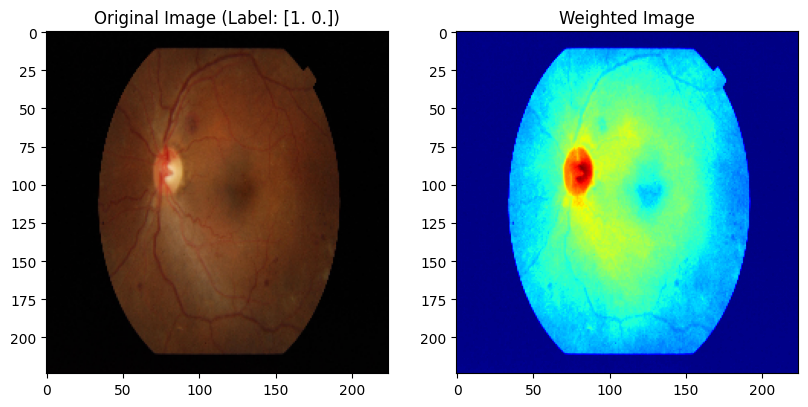

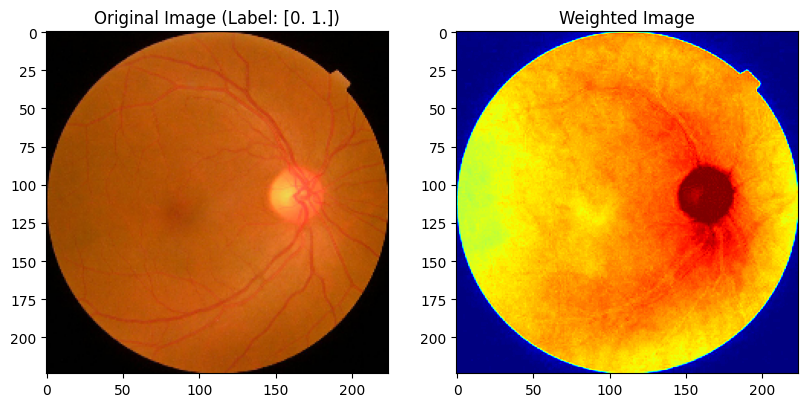

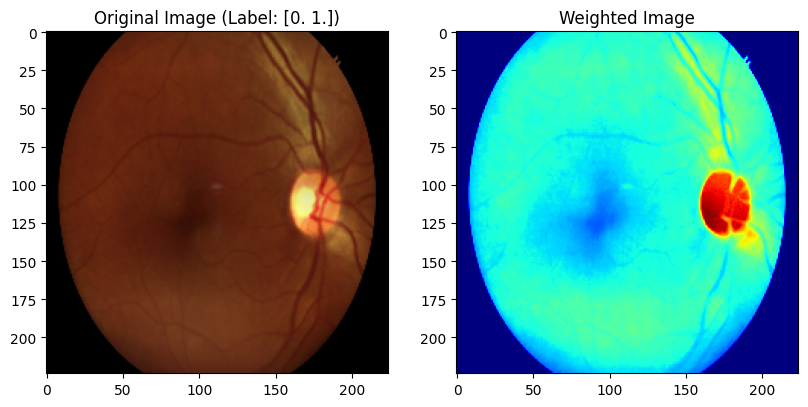

In [19]:
num_images = 10
output_layer_name1 = model1.output.name.split("/")[0]
output_layer_name2 = model2.output.name.split("/")[0]

def generate_grad_cam_cbam(model, img_array, target_layer, output_layer):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(target_layer).output, model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = model_output[:, 1]  
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    max_value = np.max(heatmap)
    if max_value != 0:
        heatmap /= max_value
        
    return heatmap

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]

    heatmap1 = generate_grad_cam_cbam(model1, img_array, model1_layer, output_layer_name1)
    heatmap2 = generate_grad_cam_cbam(model2, img_array, model2_layer, output_layer_name2)

    target_size = max(heatmap1.shape[0], heatmap2.shape[0]), max(heatmap1.shape[1], heatmap2.shape[1])
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]
    heatmap2_resized = tf.image.resize(heatmap2[..., np.newaxis], target_size)[..., 0]
    heatmap = (heatmap1_resized + heatmap2_resized) / 2.0

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224))[..., 0]
    heatmap_weighted = heatmap_resized * 1

    weighted_img = heatmap_weighted[..., np.newaxis] * img_array[0]
    weighted_img /= np.max(weighted_img) 

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Weighted Image')

    plt.show()

In [20]:
kappa_score = cohen_kappa_score(all_true_labels, predicted_labels)

# Print the Kappa score
print("Kappa Score:", kappa_score)

Kappa Score: 0.9230905756374608


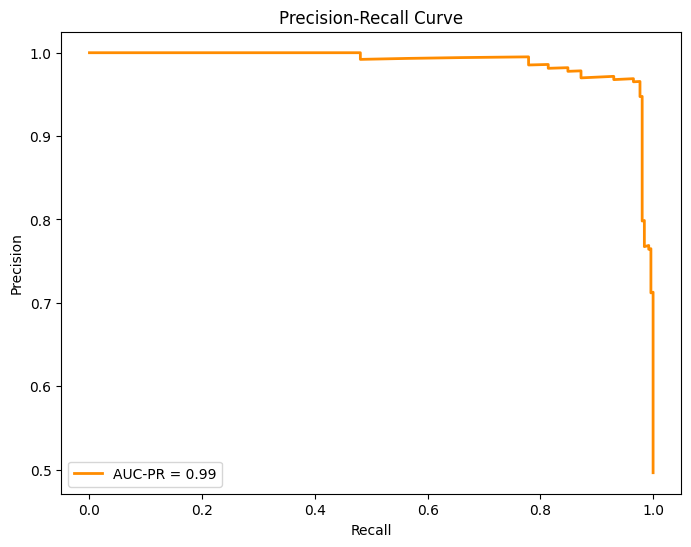

In [21]:
precision, recall, _ = precision_recall_curve(all_true_labels, predictions[:, 1])
auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [22]:
import pandas as pd
history_df1 = pd.DataFrame(history.history)

history_df1.to_csv('my_model.csv', index=False)